In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

The goal of this code is to generate a polynomial with given combinatorics. Using principles from Teichmüller theory, one can prove the convergence of this algorithm to the desired polynomial.

Throughout the documentation, we use 'rational angle' to refer to an element of $\mathbb{Q}/\mathbb{Z}$ and may omit the implicit multiple of $2\pi$ where appropriate.


The underlying math comes from this paper by John Hubbard and Dierk Schleicher https://pi.math.cornell.edu/~hubbard/SpidersFinal.pdf.
This implementation is by Jeffrey Lantz and Riley Guyett.

In [250]:
def orient(point1,point2,point3):
    ## returns True if the three points are clockwise oriented
    return ((point2.imag-point1.imag)*(point3.real-point2.real)) >((point2.real-point1.real)*(point3.imag-point2.imag))

def intersect_curves(curve,point1,point2):
    intersects = [intersect_segs([curve[i],curve[i+1]],[point1,point2]) for i in range(len(curve)-1)]
    return [prev := 0] and [prev := prev + intersected for intersected in intersects]
    
    
    
    #count = 0
    #intersect_array = np.empty(len(curve)-1)
    #for i in range(len(curve)-1):
    #    if intersect_segs(curve[i:i+2],[point1,point2]):
    #        count += 1
    #    intersect_array[i]= count
    #return intersect_array
    

def intersect_segs(seg1,seg2):
    ## seg1 and seg2 are numpy arrays of 2 complex points
    o1 = orient(seg1[0], seg1[1], seg2[0])
    o2 = orient(seg1[0], seg1[1], seg2[1])
    o3 = orient(seg2[0], seg2[1], seg1[0])
    o4 = orient(seg2[0], seg2[1], seg1[1])
    return (o1 != o2) and (o3 != o4)


class Spider:
    ## A spider is the fundamental object of our space.
    ## It has legs that go off to infinity (or |z| = exp(2). Close enough)
    ## The legs land at points in C and do not cross.
    ## Spiders may be equivalent under a certain homotopy condition, which we currently ignore
    
    
    ## A spider may be is defined by a rational angle
    ## In this case, it has legs going radially with endpoints at exp(2^j 2pi i theta)
    def __init__(self, theta=0, endpoints=np.empty(0), legs=np.empty((0,0)), divline=np.empty(0), knead = np.empty(0), prelength = 0):
        if theta == 0: # If we are given the endpoints & legs
            self.endpoints = endpoints # Give the endpoints
            self.legs = legs # Give the legs
            self.divline = divline
        else: # If we are given the starting angle
            angles = np.array([theta, theta*2 % 1]) # Initialize an array of angles
            while not any(np.abs(angles[-1]*2 % 1 - angles[:-1]) < math.pow(10,-6)): # While the angles in the array differ by at least 10^-6
                angles = np.append(angles, angles[-1]*2 % 1) # Add double the last angle to the array
            self.prelength = (np.abs(angles[-1]*2 % 1 - angles[:-1]) < math.pow(10,-6)).nonzero()[0][0]
            self.endpoints = np.exp(2 * np.pi * 1j * angles) # The endpoints are points on the unit circle of those angles
            self.legs = np.kron(np.linspace(1, 3, 100), self.endpoints[:, np.newaxis]) # Legs are straight lines perpindicular to the circle
            self.divline = np.linspace(-1,1,100)*np.sqrt(self.endpoints[0]) # Constructs the appropriate line dividing the space in two halves
            self.knead = [] # Initialize the kneading sequence
            for point in self.endpoints: # For each endpoint
                if round((point / np.sqrt(self.endpoints[0])).imag,7) > 0: # If the endpoint is in region A
                    self.knead.append('A') # Give it a kneading value of 'A'
                elif round((point / np.sqrt(self.endpoints[0])).imag,7) < 0: # If the endpoint is in region B
                    self.knead.append('B') # Give it a kneading value of 'B'
                elif round((point / np.sqrt(self.endpoints[0])).real,7) == -1: # If the endpoint hits the cc boundary of A
                    self.knead.append('*1') # Give it a kneading value of '*1'
                elif round((point / np.sqrt(self.endpoints[0])).real,7) == 1: # If the endpoint hits the C boundary of A
                    self.knead.append('*2') # Give it a kneading value of '*2'
        
    def graph(self,draw_circ=False): # To graph the spider
        plt.figure(figsize=(10,10)) # Makes a 10x10 grid
        for leg in self.legs: # For each leg
            plt.plot(leg.real, leg.imag, 'black') # Plot the leg in black
        if draw_circ == True:
            plt.plot(np.exp(np.linspace(0, 2*np.pi, 100) * 1j).real, np.exp(np.linspace(0, 2*np.pi, 100) * 1j).imag, 'black') # Plot the unit circle in black
        limit=5 # Set limits for axis
        plt.plot(self.divline.real,self.divline.imag,'red') # Plots the dividing line in red
        plt.scatter(self.endpoints.real,self.endpoints.imag, s=20, marker='o') # Plots the endpoints of the spider in blue
        i = 0 # Intializing an index
        while i < len(self.endpoints): # While this is a valid index for an endpoint
            plt.text(1.1*self.endpoints[i].real, 1.1*self.endpoints[i].imag,'z_'+str(i+1)) # Label the endpoints
            i += 1 # Increase the index
        plt.xlim((-limit,limit)) # Plot real axis
        plt.ylim((-limit,limit)) # Plot imaginary axis
        plt.ylabel('Imaginary') # Label the imaginary axis
        plt.show() # Show the plot
    
    def update(self):
        z_2 = self.endpoints[1] # Select z_2 so we don't have to keep calling it
        i = 0 # Initialize an index
        new_endpoints= np.empty(0) # Initialize an array for future endpoints
        while i <len(self.endpoints)-1: # While i is an index of an endpoint except for the last endpoint
            if self.knead[i] == 'A' or self.knead[i] == '*1':
                new_endpoints= np.append(new_endpoints, 2*np.sqrt(self.endpoints[i+1]/z_2)-2) # Compute where the corresponding new endpoint is
            if self.knead[i] == 'B' or self.knead[i] == '*2':
                new_endpoints= np.append(new_endpoints, -2*np.sqrt(self.endpoints[i+1]/z_2)-2) # Compute where the corresponding new endpoint is
            i += 1 # Increase the index
        new_endpoints= np.append(new_endpoints, 2*np.sqrt(2*self.endpoints[len(self.endpoints)-1]/z_2)-2) # Add the last future endpoint
        new_divline = np.empty(0) # Initialize a new dividing line
        for point in self.divline: # For each point in the current dividing line
            new_divline= np.append(new_divline, 2*np.sqrt(point/z_2)-2) # Compute where that point goes under p^-1 and append to the new dividing line
        new_legs = np.empty(100) # Initialize new set of legs
        i = 0
        while i < len(self.endpoints):
            new_leg = np.empty(0) # Initialize a new leg
            for point in self.legs[i]:
                if self.knead[i] == 'A' or self.knead[i] == '*1':
                    new_leg= np.append(new_leg, 2*np.sqrt(point/z_2)-2) # Add a new point to the new leg under p^-1
                if self.knead[i] == 'B' or self.knead[i] == '*2':
                    new_leg= np.append(new_leg, -2*np.sqrt(point/z_2)-2) # Add a new point to the new leg under p^-1
            new_legs = np.vstack((new_legs,[new_leg])) # Combine the new legs into a list of new legs
            i += 1
        self.endpoints = new_endpoints # Change the endpoints of the spider to the new endpoints
        self.legs = new_legs # Change the legs of the spider to the new legs
        self.divline = new_divline # Change the dividing line of the spider to the new dividing line
        
        
    def listpts(self):
        print("knead", self.knead) # Prints the kneading sequence
        print("endpoints:", self.endpoints) # Prints the list of endpoints
        print("new endpoints:",self.update()) # Prints the list of future endpoints
        print("legs:", self.legs) # Prints the legs

def shift_spider(spider, value):
    for i in range(len(spider.endpoints)):
        spider.endpoints[i] = spider.endpoints[i] - value
    for i in range(len(spider.legs)):
        for j in range(len(spider.legs[i])):
            spider.legs[i][j] = spider.legs[i][j] - value
        
def update_spider(spider,d=2):
    z_2 = spider.endpoints[1]
    #new line is the two lifts of leg of z_1, with points going between extremes
    new_divline = np.append(-2*np.sqrt(spider.legs[0][-1:0:-1]/z_2)-2,
                                2*np.sqrt(spider.legs[0]/z_2)-2)    
    new_endpoints = np.empty(len(spider.endpoints), dtype=np.cdouble)
    for i in range(len(spider.endpoints[:-1])):
        if intersect_curves(new_divline,2*np.sqrt(spider.endpoints[i]/z_2)-2,0)[-1] % 2 == (spider.knead[i]=='B' or spider.knead[i]=='*2'):
            new_endpoints[i] = 2*np.sqrt(spider.endpoints[i+1]/z_2)-2
        else:
            new_endpoints[i] = -2*np.sqrt(spider.endpoints[i+1]/z_2)-2
    if intersect_curves(new_divline,2*np.sqrt(spider.endpoints[spider.prelength]**2/z_2)-2,0)[-1] % 2 == (spider.knead[-1]=='B' or spider.knead[-1]=='*2'):
        new_endpoints[-1] = 2*np.sqrt(2*spider.endpoints[spider.prelength]/z_2)-2
    else:
         new_endpoints[-1] = -2*np.sqrt(2*spider.endpoints[-1]/z_2)-2
    return Spider(endpoints=new_endpoints,legs=spider.legs, divline=new_divline, knead = spider.knead, prelength=spider.prelength)

In [271]:
favorite = Spider(theta=1/100)

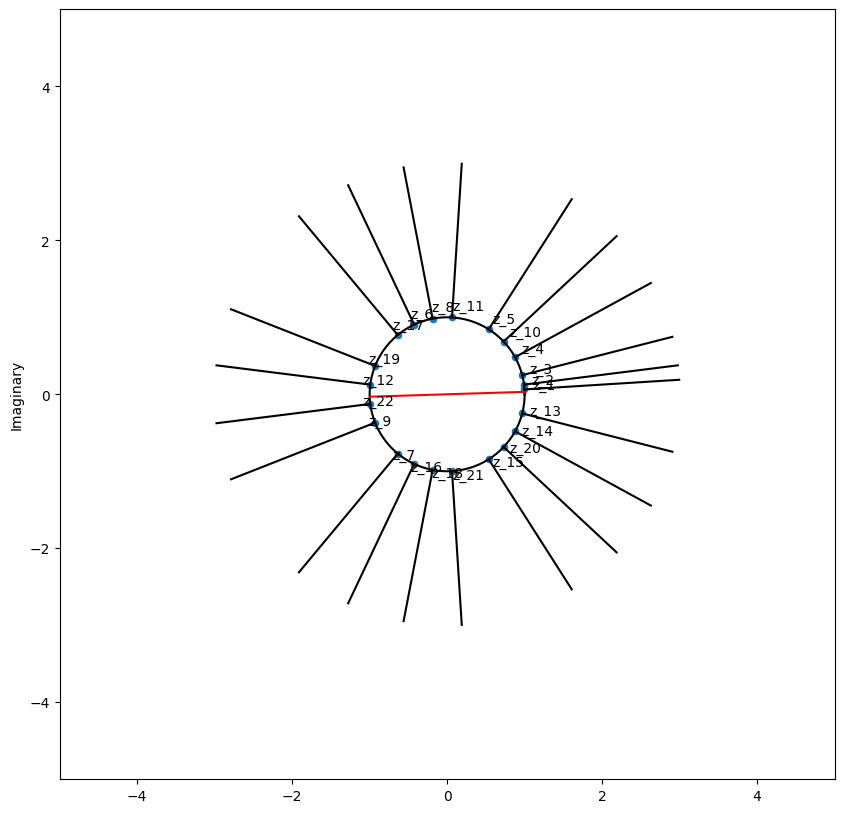

In [272]:
favorite.graph(True)

In [273]:
shift = favorite.endpoints[0]
shift_spider(favorite,shift)
z_2_orig = favorite.endpoints[1]
new = update_spider(favorite)

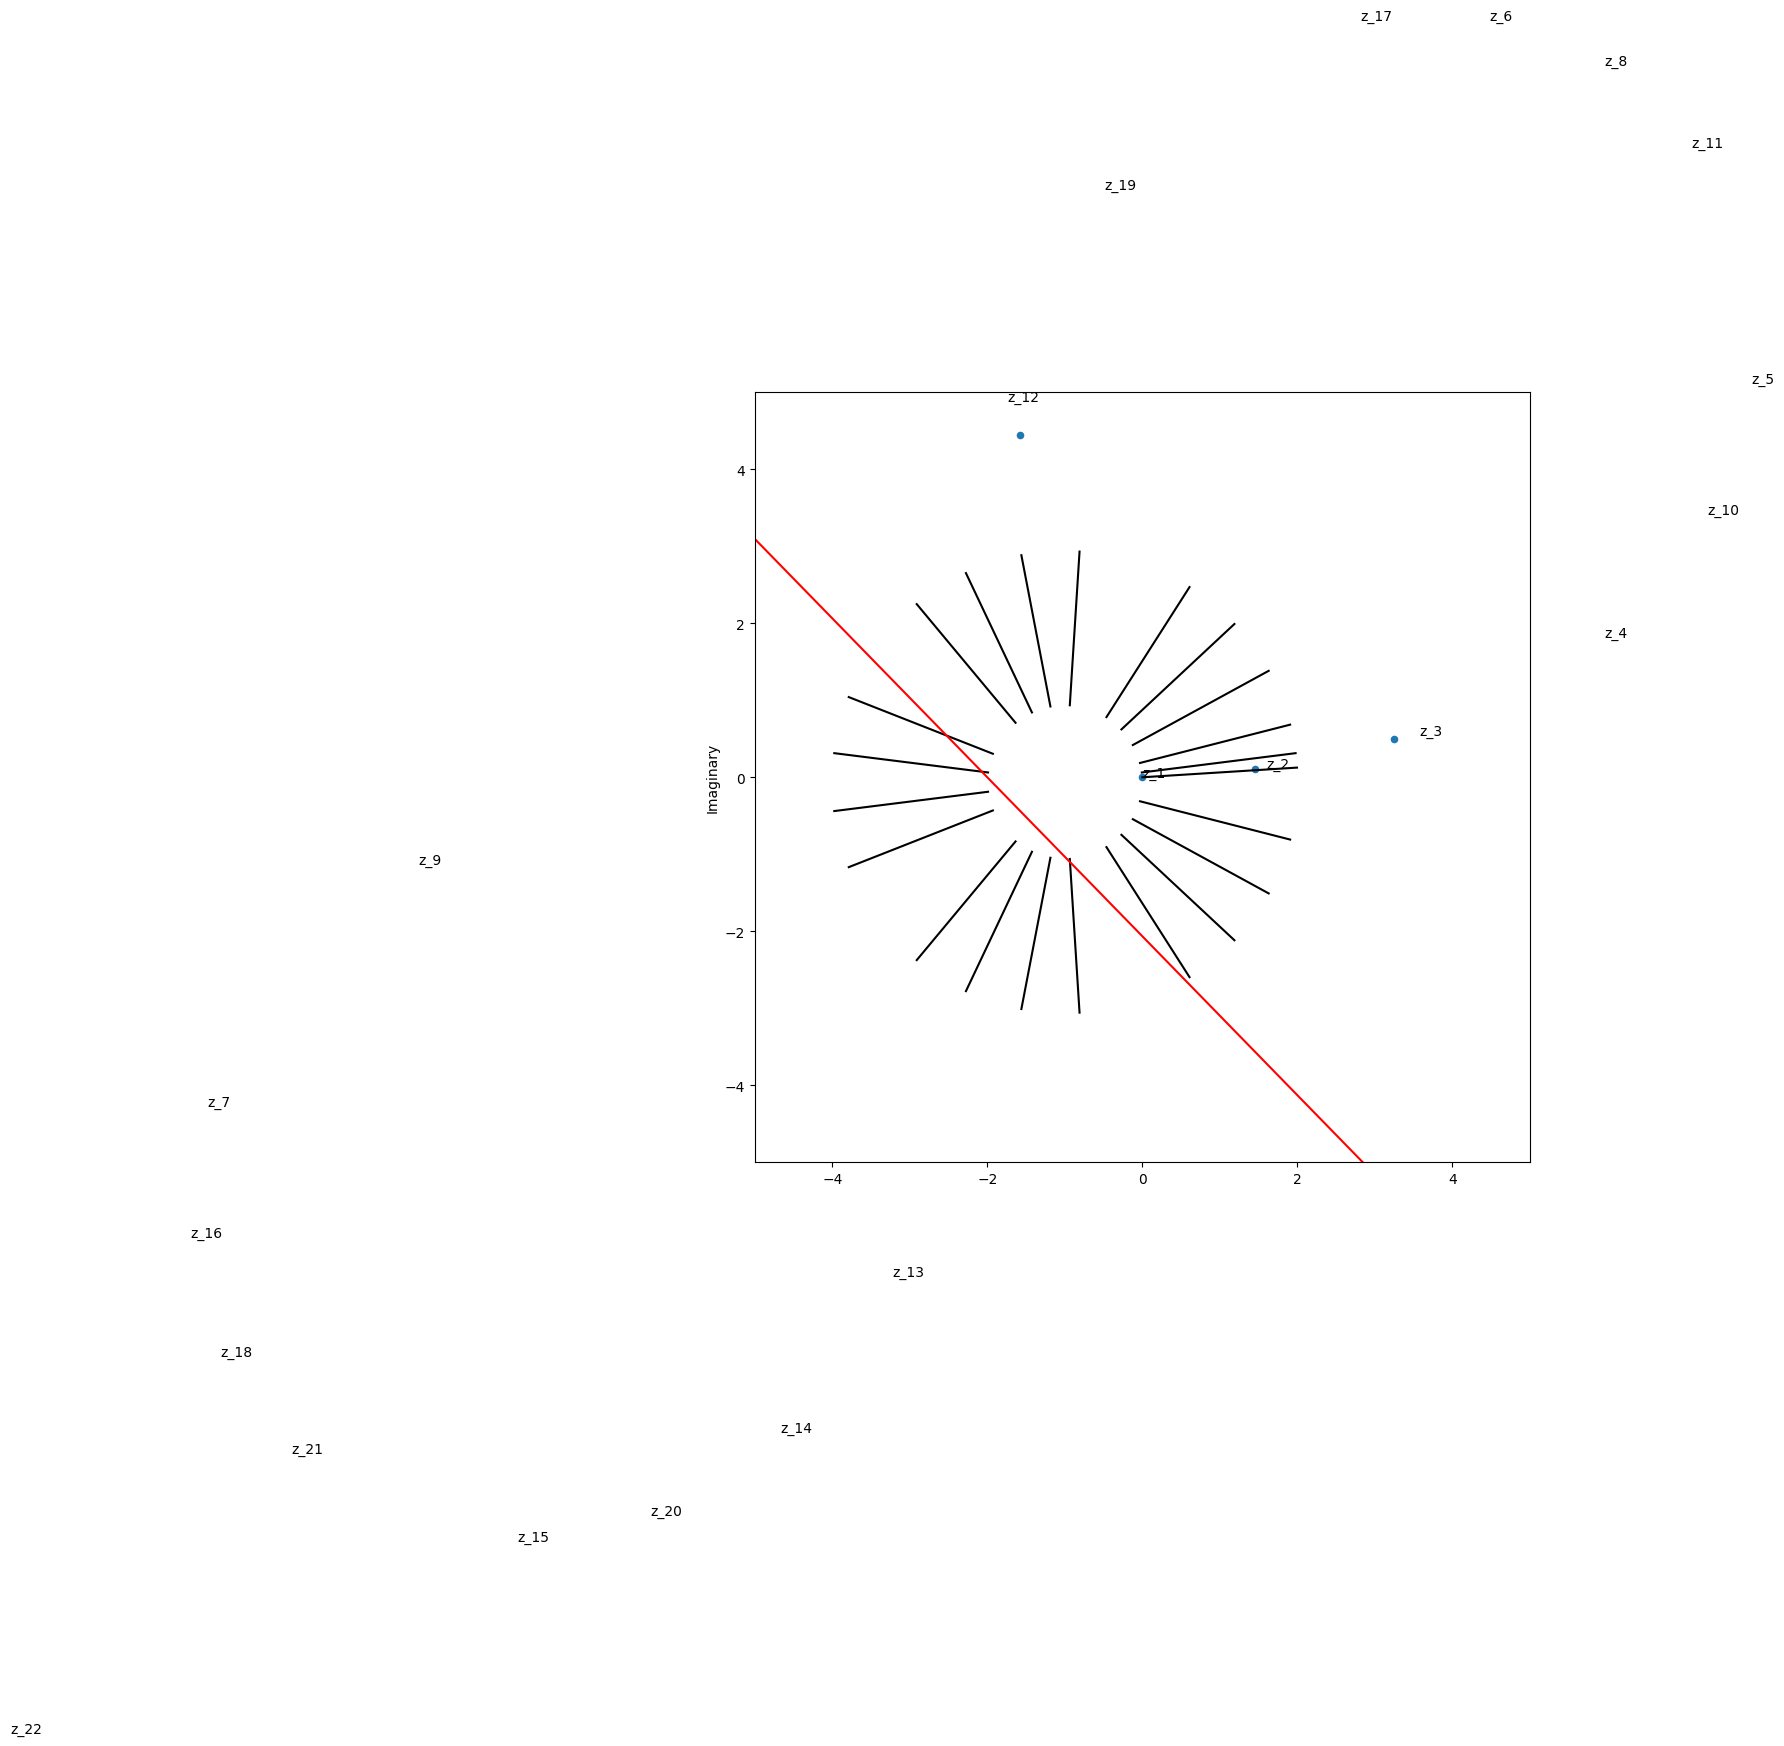

In [274]:
new.graph()

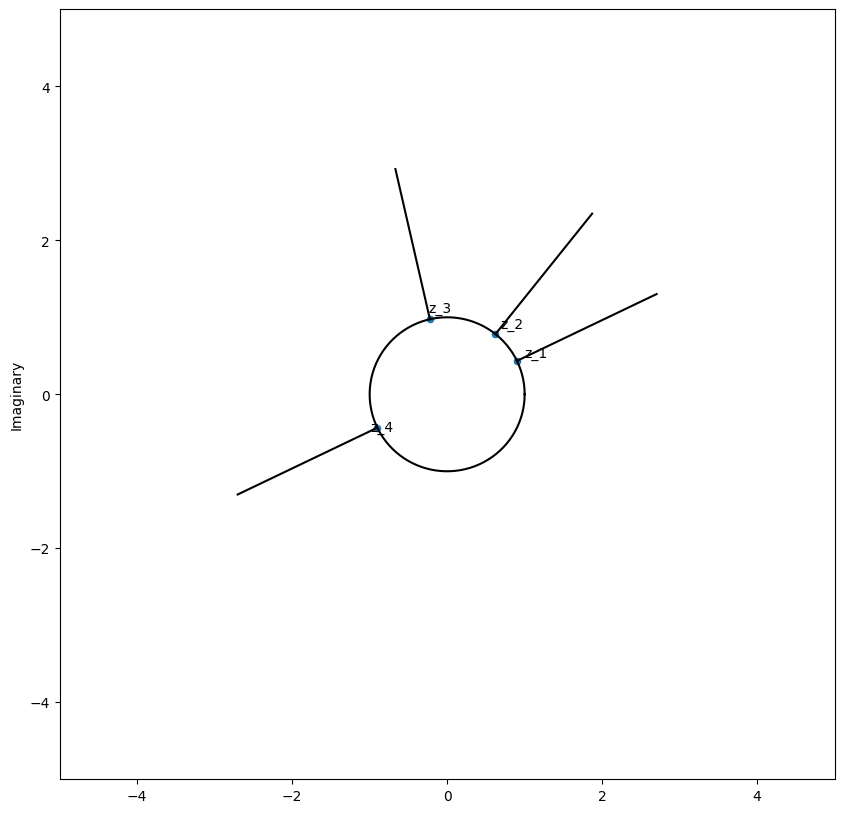

In [269]:
test_spider = Spider(endpoints=np.append(0,z_2_orig*(1+new.endpoints[:-1]/2)**2), legs=new.legs)
shift_spider(test_spider,-1*shift)
test_spider.graph(True)

In [270]:
print(test_spider.endpoints)
print(favorite.endpoints+shift)
print(favorite.prelength)

[ 0.90096887+0.43388374j  0.6234898 +0.78183148j -0.22252093+0.97492791j
 -0.90096887-0.43388374j]
[ 0.90096887+0.43388374j  0.6234898 +0.78183148j -0.22252093+0.97492791j
 -0.90096887-0.43388374j]
1
